<font color = 'Orange' size = 6> Satellite Dataset-RSI-CB256 trained with VGG16 Architecture</font>

#### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as td
import torchvision.datasets as datasets
from torchvision import models
from sklearn.model_selection import KFold
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import time
import os, random

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### EDA (Exploratory Data Analysis) and Preprocessing

In [2]:
root_dir = r'/content/drive/MyDrive/AI Project/Datasets/Satellite Dataset-RSI-CB256/data'

In [3]:
def count_target_classes(root_dir):
    '''return count of number of images per class'''
    target_classes = {}
    for folder in sorted(os.listdir(root_dir)):
        data_path_for_image_folder = root_dir+ '/'+str(folder) + '/'
        target_classes[str(folder)] = len([image_filename for image_filename in sorted(os.listdir(data_path_for_image_folder))])
    return target_classes

In [4]:
dict_class_count = count_target_classes(root_dir)

In [5]:
print("Total number of images for the datasets are :",sum(dict_class_count.values()))

Total number of images for the datasets are : 5631


In [6]:
def plot_hist(dict_target_count):
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(8,6))
    plt.bar(dict_target_count.keys(), dict_target_count.values(), 
            color= ['aqua', 'gold', 'green', 'blue'], edgecolor='k')
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Number of images per class")
    plt.show()
    plt.close()

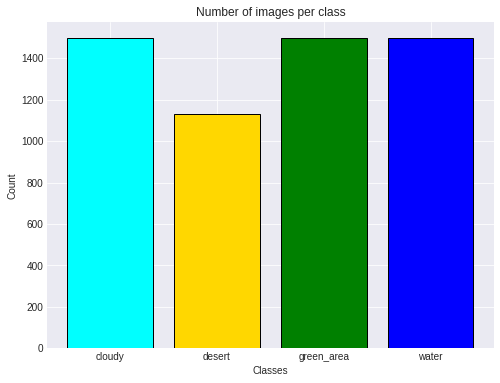

In [7]:
plot_hist(dict_class_count)

In [8]:
def print_images(root_dir):
    '''return count of number of images per class'''
    plt.style.use('seaborn-white')
    images_plt=[]
    classes=[]
    f, axarr = plt.subplots(1,4, figsize=(15,15)) 
    for folder in sorted(os.listdir(root_dir)):
      image_folder = root_dir+ '/'+str(folder) + '/'
      classes.append(str(folder))
      images_plt.append(image.imread(random.choice([image_folder+image_filename for image_filename in sorted(os.listdir(image_folder))])))

    axarr[0].imshow(images_plt[0])
    axarr[0].set_title(classes[0])
    axarr[1].imshow(images_plt[1])
    axarr[1].set_title(classes[1])
    axarr[2].imshow(images_plt[2])
    axarr[2].set_title(classes[2])
    axarr[3].imshow(images_plt[3])
    axarr[3].set_title(classes[3])
    plt.show
    

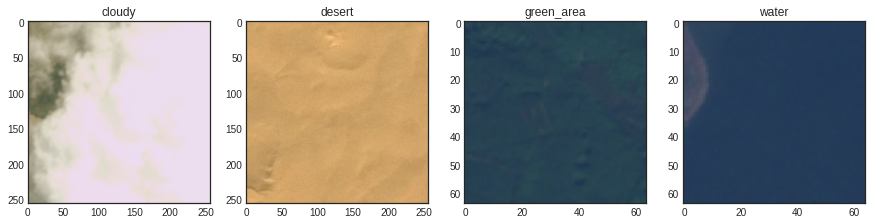

In [24]:
print_images(root_dir)

In [9]:
def load_dataset(path, test_split, batch_size, input_size):

    # normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
    #                                  std=[0.5, 0.5, 0.5])
    
    transform_dict = {'src':  transforms.Compose([transforms.Resize(input_size),
                                  #  transforms.RandomRotation(30),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.RandomVerticalFlip(),
                                   transforms.RandomAdjustSharpness(0.2),
                                   transforms.RandomAutocontrast(),
                             transforms.ToTensor()])}

    data = datasets.ImageFolder(root=path, transform=transform_dict["src"])

    test_size = int(len(data) * test_split)
    train_size = len(data)- test_size

    train_dataset, test_dataset = td.random_split(data, [train_size, test_size])

    return train_dataset,test_dataset

In [10]:
dataset, test_dataset = load_dataset(root_dir, test_split=0.2, batch_size=32, input_size=[64,64])

In [12]:
def plot_data_loader(data_loader, gridDims):
    plt.style.use('seaborn-white')
    # plt.figure(figsize=(8,6))
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(15,15))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = dataiter.next()
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

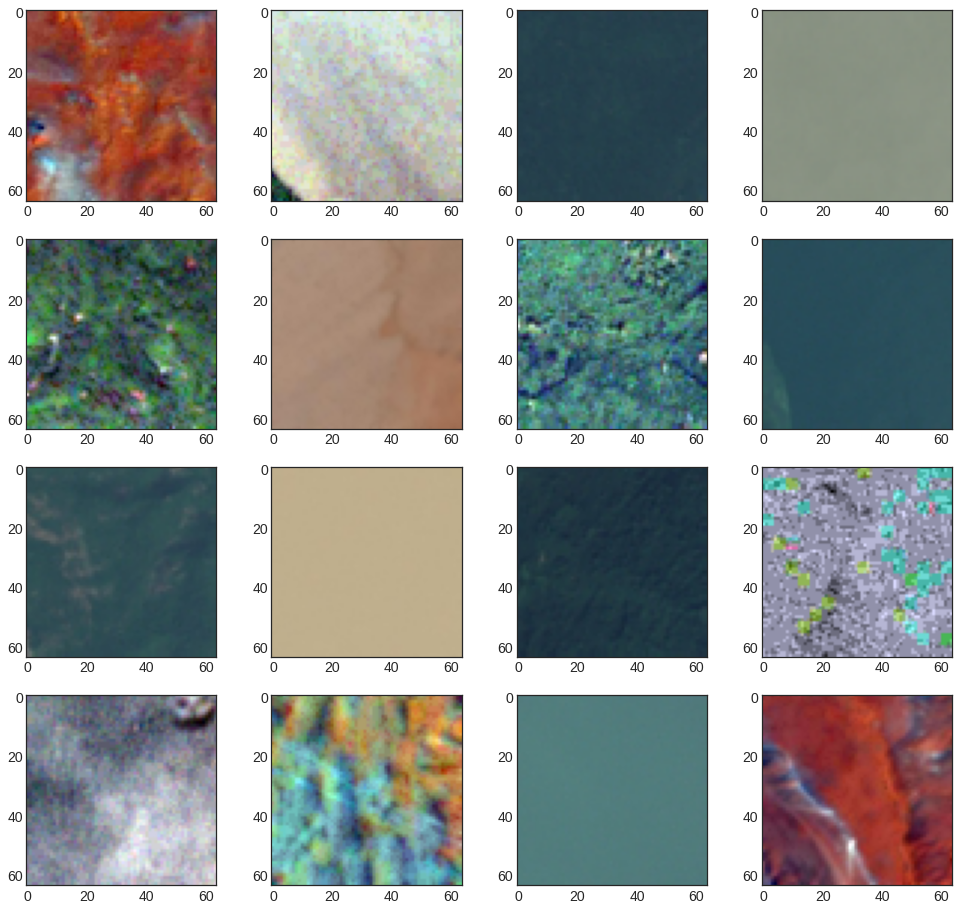

In [ ]:
train_loader = td.DataLoader(dataset, batch_size = 32, shuffle=True,
                               pin_memory=True, drop_last = False, num_workers = 0)
plot_data_loader(train_loader, (4,4))

#### Load VGG16 Model 

In [11]:
model = models.vgg16()  # By default, no pre-trained weights are used.
# define the loss function
criterion = nn.CrossEntropyLoss()
#Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=8ddb596da01b096942409cb64ea71659a1791bc73fecb85211ccba3430711c48
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


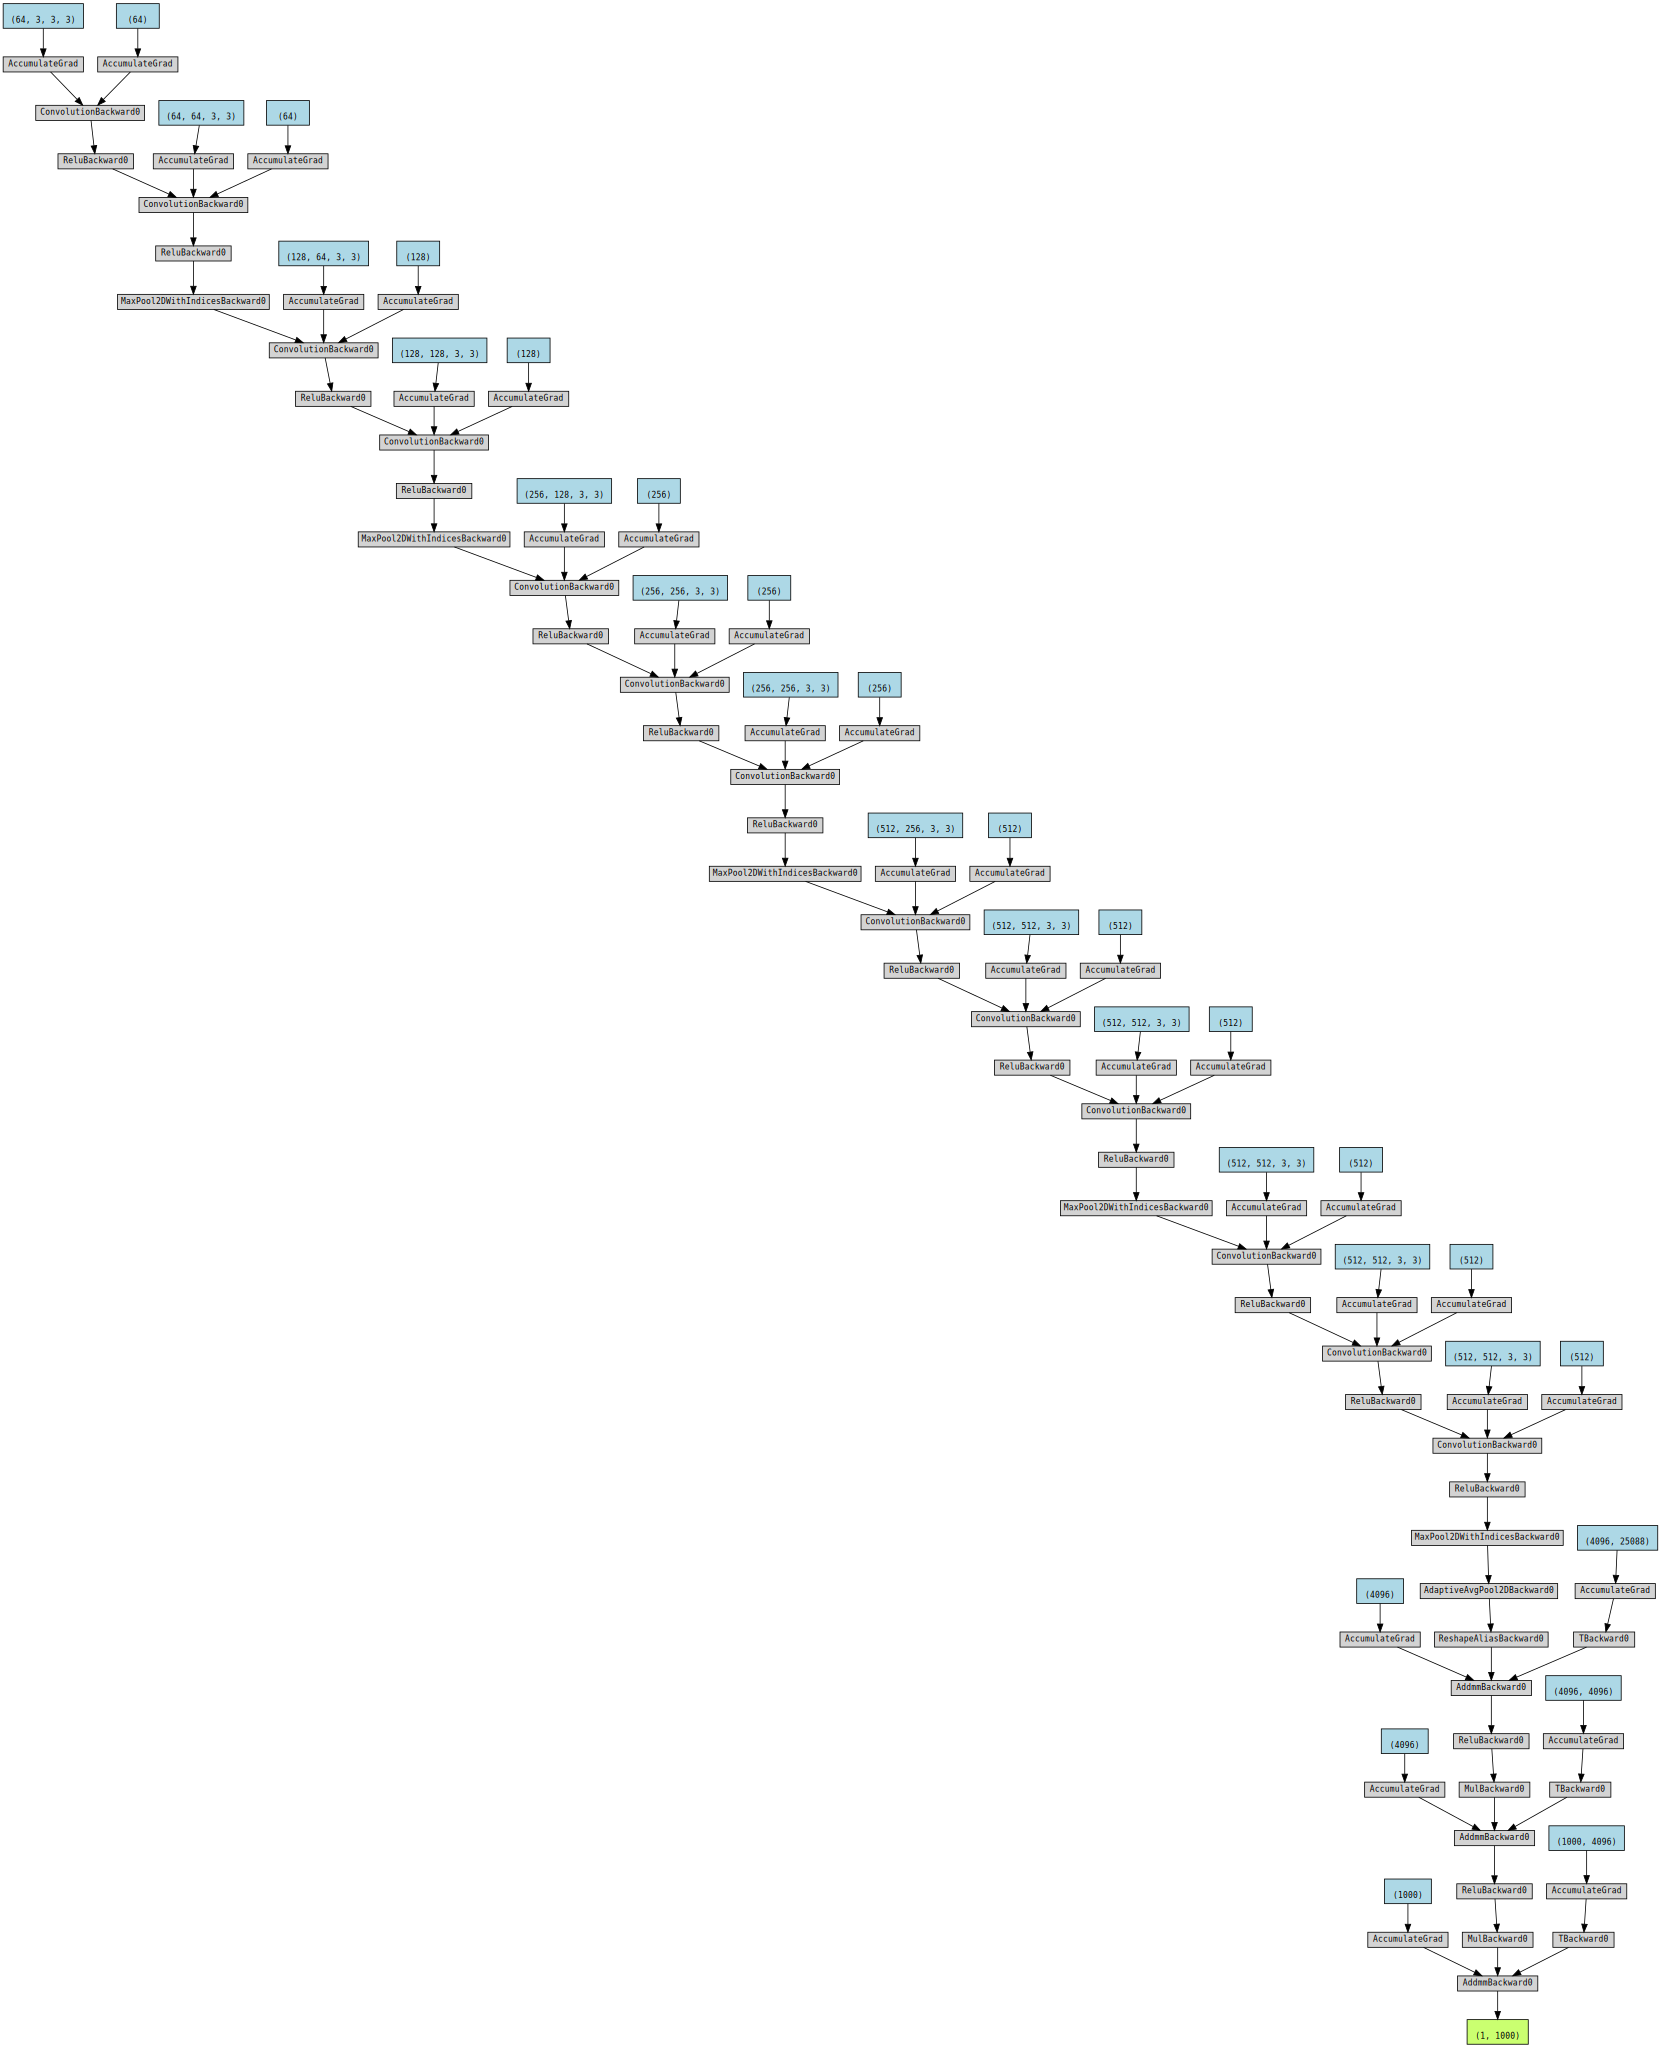

In [24]:
from torchviz import make_dot

x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
out = model(x)
# make_dot(out, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")  #for saving the model 
make_dot(out)

#### Train the Model

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print("Device: {}".format(device))

model.to(device)

# k-fold validation i.e. it divides the dataset into 9 parts for training and the remaining part for test.
splits = KFold(n_splits = 5, shuffle=True, random_state=42) 
num_epochs=10
batch_size=32
foldperepoch={}

Device: cuda:0


In [20]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss = 0.0
    train_correct_pred = 0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        # Forward pass
        output = model(images)
        loss = loss_fn(output,labels)
        # Backprop and optimisation
        loss.backward()
        optimizer.step()
        # Train loss
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct_pred += (predictions == labels).sum().item()

    return train_loss, train_correct_pred
  
def valid_epoch(model,device,dataloader,loss_fn):
  valid_loss = 0.0
  val_correct_pred = 0

  #evaluate the mdoel
  model.eval()
  for images, labels in dataloader:

      images,labels = images.to(device),labels.to(device)
      output = model(images)
      loss = loss_fn(output,labels)
      # val loss
      valid_loss += loss.item()*images.size(0)
      scores, predictions = torch.max(output.data,1)
      val_correct_pred += (predictions == labels).sum().item()

  return valid_loss, val_correct_pred

In [21]:
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = td.SubsetRandomSampler(train_idx)
    test_sampler = td.SubsetRandomSampler(val_idx)
    train_loader = td.DataLoader(dataset, batch_size = batch_size, sampler=train_sampler,
                               pin_memory=True, drop_last = False, num_workers = 0)
    test_loader = td.DataLoader(dataset, batch_size = batch_size, sampler=test_sampler,
                                pin_memory=True, drop_last = False, num_workers = 0)

    history = {'train_loss': [], 'test_loss': [],'train_accuracy':[],'test_accuracy':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct = train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct  = valid_epoch(model,device,test_loader,criterion)
        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100
        print("Epoch:{}/{} Average Training Loss:{:.3f} Average Test Loss:{:.3f} Average Training Accuracy {:.2f} % Average Test Accuracy {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_accuracy'].append(train_acc)
        history['test_accuracy'].append(test_acc)

    foldperepoch['fold{}'.format(fold+1)] = history  

torch.save(model,'k_cross_VGG.pt')    

Fold 1
Epoch:1/10 Average Training Loss:1.030 Average Test Loss:0.947 Average Training Accuracy 45.95 % Average Test Accuracy 41.84 %
Epoch:2/10 Average Training Loss:0.944 Average Test Loss:0.936 Average Training Accuracy 49.36 % Average Test Accuracy 57.27 %
Epoch:3/10 Average Training Loss:0.896 Average Test Loss:0.881 Average Training Accuracy 57.69 % Average Test Accuracy 62.04 %
Epoch:4/10 Average Training Loss:0.874 Average Test Loss:0.783 Average Training Accuracy 60.52 % Average Test Accuracy 62.38 %
Epoch:5/10 Average Training Loss:0.833 Average Test Loss:0.781 Average Training Accuracy 63.49 % Average Test Accuracy 64.48 %
Epoch:6/10 Average Training Loss:0.923 Average Test Loss:0.982 Average Training Accuracy 56.58 % Average Test Accuracy 49.83 %
Epoch:7/10 Average Training Loss:0.802 Average Test Loss:0.822 Average Training Accuracy 64.01 % Average Test Accuracy 63.82 %
Epoch:8/10 Average Training Loss:0.826 Average Test Loss:0.822 Average Training Accuracy 64.32 % Average

**Calculate the average score in every fold**

In [22]:
test_loss_fold, train_loss_fold, test_acc_fold, train_acc_fold=[],[],[],[]
k=5
for f in range(1,k+1):

     train_loss_fold.append(np.mean(foldperepoch['fold{}'.format(f)]['train_loss']))
     test_loss_fold.append(np.mean(foldperepoch['fold{}'.format(f)]['test_loss']))

     train_acc_fold.append(np.mean(foldperepoch['fold{}'.format(f)]['train_accuracy']))
     test_acc_fold.append(np.mean(foldperepoch['fold{}'.format(f)]['test_accuracy']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(train_loss_fold),np.mean(test_loss_fold),np.mean(train_acc_fold),np.mean(test_acc_fold)))     


Performance of 5 fold cross validation
Average Training Loss: 0.735 	 Average Test Loss: 0.716 	 Average Training Acc: 69.48 	 Average Test Acc: 70.67


In [26]:
test_loader = td.DataLoader(test_dataset, batch_size = batch_size, shuffle=True,
                            pin_memory=True, drop_last = False, num_workers = 0)


test_loss, test_correct  = valid_epoch(model, device, test_loader, criterion)
test_loss = test_loss / len(test_loader.sampler)
test_acc = test_correct / len(test_loader.sampler) * 100
print("Test Loss:{:.3f} Test Accuracy {:.2f} %".format(test_loss, test_acc))

Test Loss:0.566 Test Accuracy 79.75 %


In [43]:
def plot_model(history):
  plt.style.use('default')
  f, axarr = plt.subplots(2,1, figsize=(10,8)) 

  axarr[0].plot(history['train_loss'], label="train_loss")
  axarr[0].plot(history['test_loss'], label="test_loss")
  axarr[0].legend()
  axarr[0].set(xlabel='Step', ylabel='Loss')
  axarr[0].set_title("Train vs Validation Loss")
  

  axarr[1].plot(history['train_accuracy'], label="train_accuracy")
  axarr[1].plot(history['test_accuracy'], label="test_accuracy")
  axarr[1].legend()
  axarr[0].set(xlabel='Step', ylabel='Accuracy')
  axarr[1].set_title("Train vs Validation Accuracy")


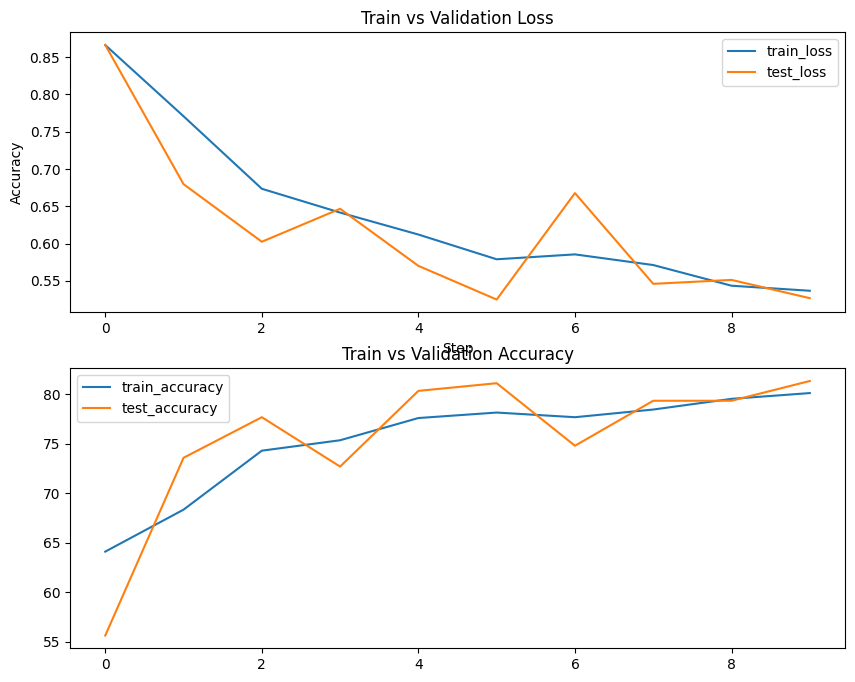

In [44]:
plot_model(history)